<a href="https://colab.research.google.com/github/210124cse-jpg/ML_CNN/blob/main/210124_ML_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
!git clone https://github.com/210124cse-jpg/ML_CNN.git


fatal: destination path 'ML_CNN' already exists and is not an empty directory.


In [7]:
!pip install torch torchvision matplotlib


In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import transforms
from PIL import Image
import os
import matplotlib.pyplot as plt


In [11]:
# Mapping class names to numeric labels
class_map = {
    'apple': 0,
    'banana': 1,
    'Orange': 2,
    'Pineapple': 3,
    'watermelon': 4,
    'kiwi': 5,
    'strawberry': 6,
    'cherry': 7,
    'avocado': 8,
    'Mango': 9
}

# Custom Dataset class
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, img_folder, transform=None):
        self.img_folder = img_folder
        self.transform = transform
        self.img_names = []
        self.labels = []  # To store the corresponding labels (numeric)

        # Collect image files from the 'custom' folder and map labels to numeric
        for file in os.listdir(img_folder):
            if file.endswith('.jpg') or file.endswith('.png'):  # Only image files
                self.img_names.append(os.path.join(img_folder, file))
                # Get the class label from the filename and map to numeric
                label = file.split('.')[0]  # Example: "apple.jpg" -> "apple"
                self.labels.append(class_map[label])  # Map the string label to numeric label

    def __len__(self):
        return len(self.img_names)

    def __getitem__(self, idx):
        img_name = self.img_names[idx]
        image = Image.open(img_name).convert('RGB')  # Open image
        label = self.labels[idx]  # Use numeric label

        if self.transform:
            image = self.transform(image)

        return image, label


In [12]:
# Define transformations (resize, convert to tensor, normalize)
transform = transforms.Compose([
    transforms.Resize((224, 224)),      # Resize images to 224x224
    transforms.ToTensor(),              # Convert to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize to match ImageNet stats
])

# Path to custom dataset
custom_data_path = '/content/ML_CNN/custom'  # Update with your custom data path

# Create dataset and dataloaders
custom_dataset = CustomDataset(custom_data_path, transform)
custom_dataloader = DataLoader(custom_dataset, batch_size=32, shuffle=True)


In [13]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(16 * 112 * 112, 120)  # Flattened size (16 * 112 * 112)
        self.fc2 = nn.Linear(120, 10)  # Output for 10 classes (apple, banana, etc.)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # Convolution -> ReLU -> Max Pooling
        x = x.view(-1, 16 * 112 * 112)  # Flatten the tensor
        x = F.relu(self.fc1(x))  # Fully connected layer
        x = self.fc2(x)  # Final output layer
        return x


In [14]:
# Initialize model, loss function, and optimizer
model = CNN()
criterion = nn.CrossEntropyLoss()  # Cross entropy loss for multi-class classification
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [23]:
# Lists to store loss and accuracy for each epoch
loss_values = []  # To store loss values
accuracy_values = []  # To store accuracy values

num_epochs = 10
for epoch in range(num_epochs):
    model.train()  # Set model to training mode
    correct = 0
    total = 0
    running_loss = 0.0

    for images, labels in custom_dataloader:
        optimizer.zero_grad()  # Zero gradients from previous step
        outputs = model(images)  # Forward pass
        loss = criterion(outputs, labels)  # Calculate loss
        loss.backward()  # Backward pass
        optimizer.step()  # Update weights

        running_loss += loss.item()  # Accumulate loss
        _, predicted = torch.max(outputs, 1)  # Get predictions
        total += labels.size(0)  # Get total labels
        correct += (predicted == labels).sum().item()  # Count correct predictions

    accuracy = 100 * correct / total  # Calculate accuracy
    accuracy_values.append(accuracy)  # Append accuracy for this epoch
    loss_values.append(running_loss / len(custom_dataloader))  # Store average loss for this epoch

    # Print out the loss and accuracy for this epoch
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(custom_dataloader)}, Accuracy: {accuracy}%")


Epoch [1/10], Loss: 8.101265120785683e-05, Accuracy: 100.0%
Epoch [2/10], Loss: 6.87022547936067e-05, Accuracy: 100.0%
Epoch [3/10], Loss: 5.8560293837217614e-05, Accuracy: 100.0%
Epoch [4/10], Loss: 5.022949699196033e-05, Accuracy: 100.0%
Epoch [5/10], Loss: 4.336440906627104e-05, Accuracy: 100.0%
Epoch [6/10], Loss: 3.770294279092923e-05, Accuracy: 100.0%
Epoch [7/10], Loss: 3.300679964013398e-05, Accuracy: 100.0%
Epoch [8/10], Loss: 2.9109165552654304e-05, Accuracy: 100.0%
Epoch [9/10], Loss: 2.585512447694782e-05, Accuracy: 100.0%
Epoch [10/10], Loss: 2.312550896022003e-05, Accuracy: 100.0%


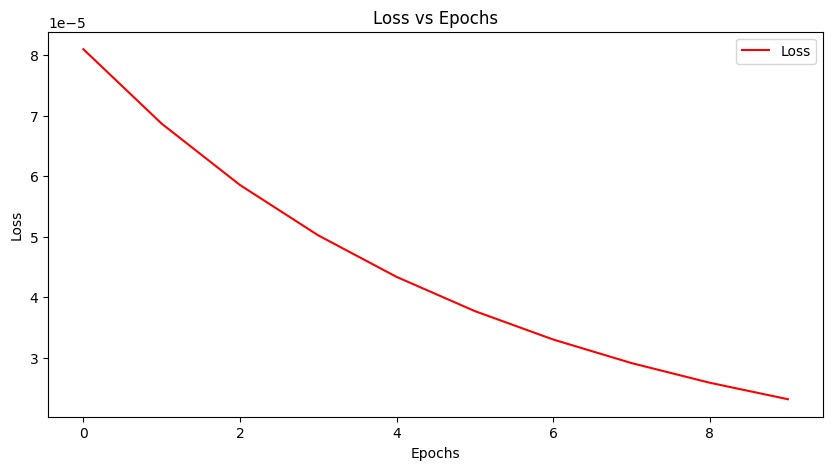

In [24]:
# Plotting Loss vs Epochs
plt.figure(figsize=(10, 5))
plt.plot(range(num_epochs), loss_values, label='Loss', color='r')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss vs Epochs')
plt.legend()
plt.show()


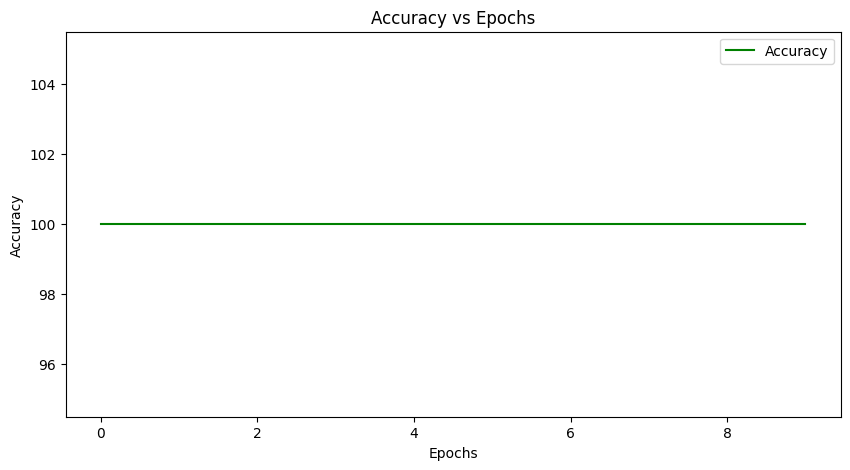

In [25]:
# Plotting Accuracy vs Epochs
plt.figure(figsize=(10, 5))
plt.plot(range(num_epochs), accuracy_values, label='Accuracy', color='g')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Epochs')
plt.legend()
plt.show()


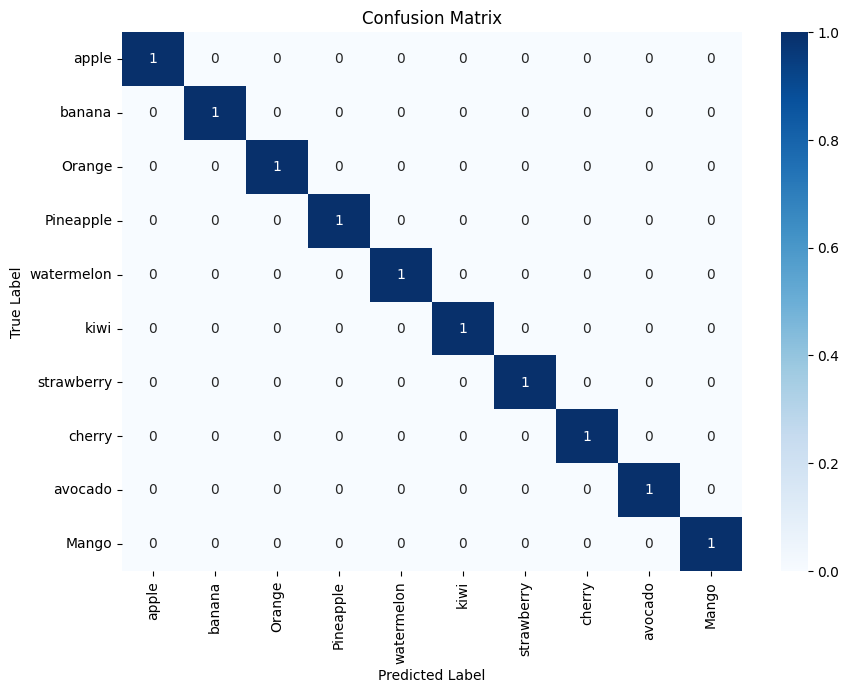

In [20]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np

# Create a confusion matrix
model.eval()
true_labels = []
predicted_labels = []

for images, labels in custom_dataloader:
    with torch.no_grad():
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
    true_labels.extend(labels.numpy())
    predicted_labels.extend(predicted.numpy())

# Compute confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Plotting the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_map.keys(), yticklabels=class_map.keys())
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


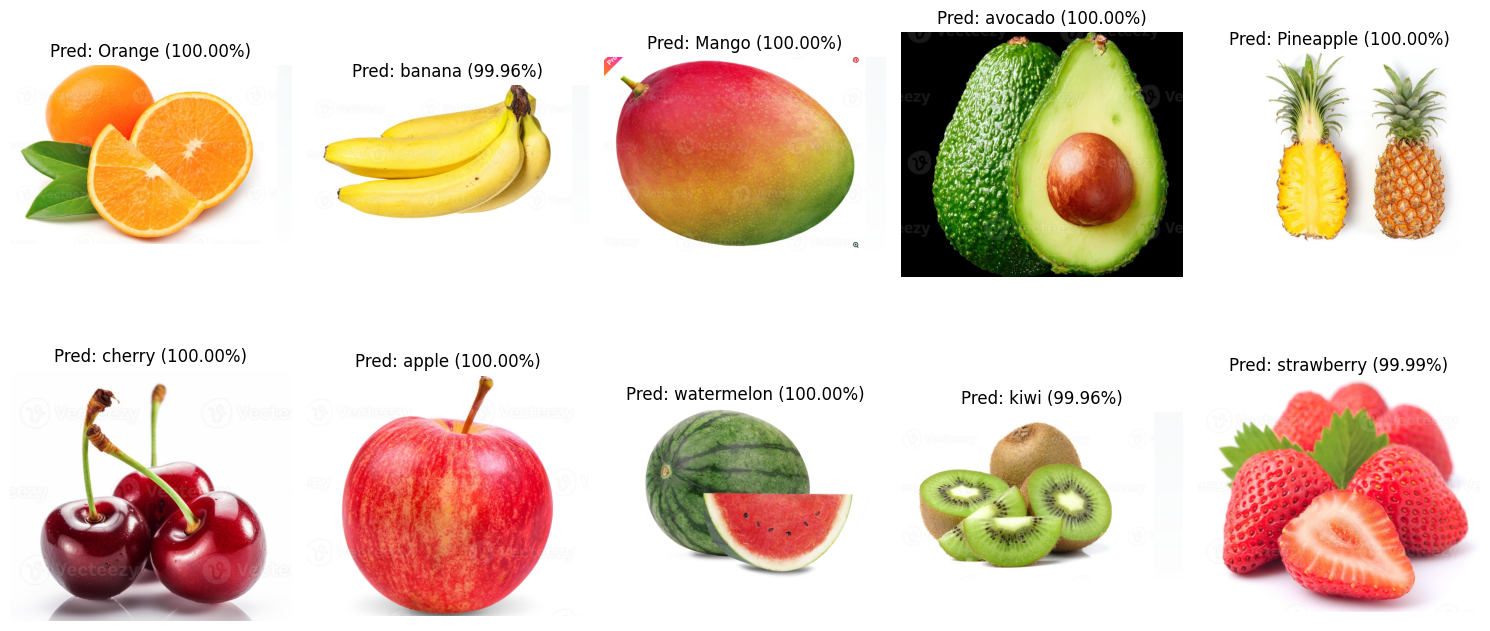

In [21]:
# Displaying 10 custom images with predicted class and confidence
model.eval()
fig, axes = plt.subplots(2, 5, figsize=(15, 8))

# Select 10 images from the custom dataset
custom_images = os.listdir(custom_data_path)[:10]  # Adjust this if needed

for i, img_name in enumerate(custom_images):
    img_path = os.path.join(custom_data_path, img_name)
    image = Image.open(img_path).convert('RGB')
    image_tensor = transform(image).unsqueeze(0)  # Apply transformation

    with torch.no_grad():
        outputs = model(image_tensor)
        probabilities = torch.softmax(outputs, dim=1)
        predicted_class = torch.argmax(probabilities)
        confidence = probabilities[0][predicted_class].item() * 100

    ax = axes[i // 5, i % 5]
    ax.imshow(image)
    ax.set_title(f'Pred: {list(class_map.keys())[predicted_class]} ({confidence:.2f}%)')
    ax.axis('off')

plt.tight_layout()
plt.show()


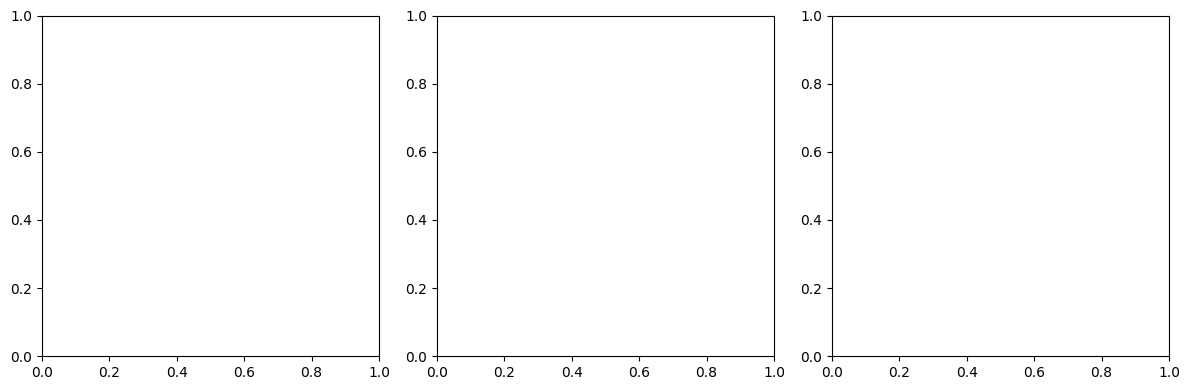

In [28]:
# Display 3 incorrect predictions for error analysis
incorrect_images = []

model.eval()

for images, labels in custom_dataloader:
    with torch.no_grad():
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

    # Identify incorrect predictions
    incorrect_indices = (predicted != labels).nonzero(as_tuple=True)[0].tolist()
    for idx in incorrect_indices:
        if len(incorrect_images) < 3:
            image = images[idx].permute(1, 2, 0).numpy()  # Convert tensor to numpy array
            incorrect_images.append((image, labels[idx].item(), predicted[idx].item()))

    if len(incorrect_images) >= 3:
        break

# Plot the incorrect predictions
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

for i, (image, true_label, predicted_label) in enumerate(incorrect_images):
    axes[i].imshow(image)
    axes[i].set_title(f'True: {list(class_map.keys())[true_label]} | Pred: {list(class_map.keys())[predicted_label]}')
    axes[i].axis('off')

plt.tight_layout()=
plt.show()
